In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import os
import scipy
import math
import imageio
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

from pathlib import Path
import subprocess

from Bio.SeqIO import read, parse
import orthoani

from multiprocess import Pool
import pandas as pd

max_pool = 16
lim_file = 200

sys.path.append('../')
sys.path.append('../../')


In [2]:
ANALYSIS_TYPE = "analysis_type"
ANALYSIS_DATA_DIR = "analysis_data_dir"
GENOME_FILE_1 = "genome_file_1"
GENOME_FILE_2 = "genome_file_2"
ORTHOANI_VAL = "orthoani_val"
KMER_LENGTH = "kmer_length"
C_VAL = "c_val"
CANONICAL = "canonical"
KMER_ANI_VAL = "kmer_ani_val"
PEARSON_COEFF = "pearson_coeff"
PEARSON_COEFF_PVAL = "pearson_coeff_pval"
SPEARMAN_COEFF = "spearman_coeff"
SPEARMAN_COEFF_PVAL = "spearman_coeff_pval"
R2_VAL_RAW = "r2_val_raw"
R2_VAL_LIN = "r2_val_lin"
DROPPED_ZEROS = "dropped_zeros"

In [3]:
data_home_dir = "../../data_temp"

species_analysis_type = "Single-Species"
species_analysis_data_dirs = {
    "Escherichia coli": (10,100),
    "Lactobacillus helveticus": (10,100),
    "Staphylococcus hominis": (10,100),
    "Mycoplasmoides pneumoniae": (10,100),
    "Brucella melitensis": (10,100),
    "Xanthomonas oryzae": (10,100)
}

genus_analysis_type = "Single-Genus"
genus_analysis_data_dirs = {
    "Pectobacterium": (10,35),
    "Morganella": (10,35),
    "Xylella": (10,35),
}

family_analysis_type = "Single-Family"
family_analysis_data_dirs = {
    "Enterobacteriaceae": (10,35),
    "Cyanobiaceae": (10,35),
    "Rhizobiaceae": (10,35)
}

family_genus_analysis_type = "Single-Family-Multi-Genus"
family_genus_analysis_data_dirs = {
    "31989": (10,35),
    "49546": (10,35),
    "186803": (10,35),
    "186817": (10,35),
}

genus_species_analysis_type = "Single-Genus-Multi-Species"
genus_species_analysis_data_dirs = {
    "Psychrobacter": (10,100),
    "Aeromonas": (10,100),
    "Rathayibacter": (10,100),
}

analysis_types = {
    species_analysis_type: species_analysis_data_dirs,
    genus_analysis_type: genus_analysis_data_dirs,
    family_analysis_type: family_analysis_data_dirs,
    family_genus_analysis_type: family_genus_analysis_data_dirs,
    genus_species_analysis_type: genus_species_analysis_data_dirs
}

In [4]:
ortho_ani_filename = "../../data_temp/ortho_ani_values.csv"
ortho_ani_dataframe = pd.read_csv(ortho_ani_filename,index_col=0)
print(ortho_ani_dataframe)

                                        genome_file_1  \
0      ../../data_temp/Single-Genus/Salmonella/64.fna   
1      ../../data_temp/Single-Genus/Salmonella/32.fna   
2      ../../data_temp/Single-Genus/Salmonella/99.fna   
3      ../../data_temp/Single-Genus/Salmonella/43.fna   
4       ../../data_temp/Single-Genus/Salmonella/7.fna   
..                                                ...   
84  ../../data_temp/Single-Genus-Multi-Species/Rat...   
85  ../../data_temp/Single-Genus-Multi-Species/Rat...   
86  ../../data_temp/Single-Genus-Multi-Species/Rat...   
87  ../../data_temp/Single-Genus-Multi-Species/Rat...   
88  ../../data_temp/Single-Genus-Multi-Species/Rat...   

                                        genome_file_2  orthoani_val  \
0      ../../data_temp/Single-Genus/Salmonella/32.fna      0.985312   
1      ../../data_temp/Single-Genus/Salmonella/99.fna      0.984921   
2      ../../data_temp/Single-Genus/Salmonella/43.fna      0.983598   
3       ../../data_temp/Single-

In [5]:
kmer_sketch_ani_filename = "../../data_temp/kmer_sketch_ani_values.csv"
kmer_sketch_dataframe = pd.read_csv(kmer_sketch_ani_filename,index_col=0).replace(0,pd.NA).dropna()
print(kmer_sketch_dataframe)

                                        genome_file_1  \
0   ../../data_temp/Single-Species/Escherichia col...   
1   ../../data_temp/Single-Species/Escherichia col...   
2   ../../data_temp/Single-Species/Escherichia col...   
3   ../../data_temp/Single-Species/Escherichia col...   
4   ../../data_temp/Single-Species/Escherichia col...   
..                                                ...   
84  ../../data_temp/Single-Genus-Multi-Species/Rat...   
85  ../../data_temp/Single-Genus-Multi-Species/Rat...   
86  ../../data_temp/Single-Genus-Multi-Species/Rat...   
87  ../../data_temp/Single-Genus-Multi-Species/Rat...   
88  ../../data_temp/Single-Genus-Multi-Species/Rat...   

                                        genome_file_2  kmer_length  c_val  \
0   ../../data_temp/Single-Species/Escherichia col...           10    200   
1   ../../data_temp/Single-Species/Escherichia col...           10    200   
2   ../../data_temp/Single-Species/Escherichia col...           10    200   
3   ../

In [6]:
corrleation_filename = "../../data_temp/correlation_values.csv"
correlation_dataframe = pd.read_csv(corrleation_filename,index_col=0)
print(correlation_dataframe)

    kmer_length  c_val  canonical  pearson_coeff  pearson_coeff_pval  \
0            10     20       True       0.907790        2.218581e-38   
0            10     20      False       0.421223        1.413929e-05   
0            10     50       True       0.911519        3.280371e-39   
0            10     50      False       0.425088        1.155857e-05   
0            10    100       True       0.916422        2.327374e-40   
..          ...    ...        ...            ...                 ...   
0            31    200       True       0.991278        2.313334e-78   
0            32    200       True       0.991865        1.131288e-79   
0            33    200       True       0.992646        1.419234e-81   
0            34    200       True       0.993159        6.186901e-83   
0            35    200       True       0.992403        5.805010e-81   

    spearman_coeff  spearman_coeff_pval               analysis_type  \
0         0.866259         5.424778e-31              Single-Spec

In [7]:
orthoani_values = ortho_ani_dataframe[ORTHOANI_VAL]

In [8]:
print(orthoani_values)

0     0.985312
1     0.984921
2     0.983598
3     0.984154
4     0.986997
        ...   
84    0.981143
85    0.953503
86    0.954359
87    0.983076
88    0.981332
Name: orthoani_val, Length: 3249, dtype: float64


In [9]:
log_orthoani_values = np.log(1 - orthoani_values)
print(log_orthoani_values)

0    -4.220711
1    -4.194440
2    -4.110354
3    -4.144817
4    -4.342611
        ...   
84   -3.970863
85   -3.068358
86   -3.086956
87   -4.079026
88   -3.980920
Name: orthoani_val, Length: 3249, dtype: float64


(array([562., 534., 468., 298., 314., 315.,  98., 347., 313.]),
 array([0.6  , 0.7  , 0.8  , 0.9  , 0.95 , 0.98 , 0.99 , 0.995, 0.998,
        1.   ]),
 <BarContainer object of 9 artists>)

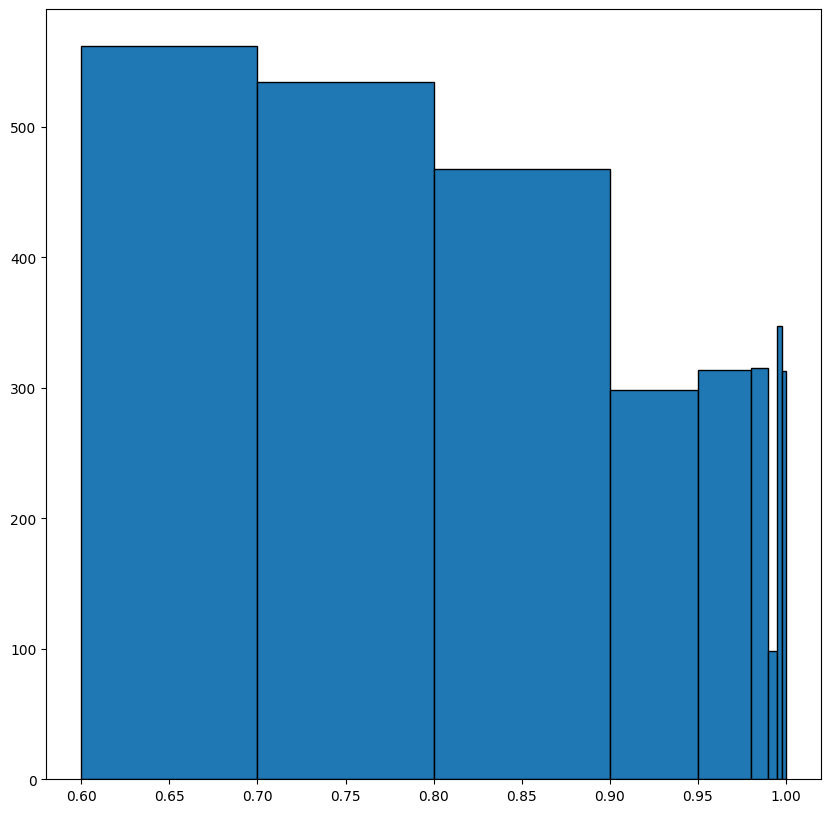

In [10]:
num_bins = 100+1
quantile = np.linspace(0,1,num_bins)
bin_edges = [0.60, 0.70, 0.80, 0.90, 0.95, 0.98, 0.99, 0.995, 0.998, 1.0] # np.quantile(orthoani_values,quantile)
plt.figure(figsize=(10,10))
plt.hist(orthoani_values,bins=bin_edges,edgecolor="black")

In [11]:
print(bin_edges)

[0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 0.995, 0.998, 1.0]


In [12]:
bin_ranges = [(b1,b2) for b1,b2 in zip(bin_edges,bin_edges[1:])]
print(bin_ranges)

[(0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 0.95), (0.95, 0.98), (0.98, 0.99), (0.99, 0.995), (0.995, 0.998), (0.998, 1.0)]


In [13]:
def partition_dataframe(dataframe, column, bin_ranges):
    return [
        dataframe[
            (dataframe[column] > st)
            & (dataframe[column] < ed)
        ] 
        for st,ed in bin_ranges
    ]

In [14]:
ortho_ani_partitioned = partition_dataframe(ortho_ani_dataframe,ORTHOANI_VAL,bin_ranges)
print(len(ortho_ani_partitioned))

9


In [15]:
combined_partitions = [
    pd.merge(
        ortho_df,
        kmer_sketch_dataframe,
        how="left",
    )
    for ortho_df in ortho_ani_partitioned
]
print(combined_partitions[-1])

                                           genome_file_1  \
0          ../../data_temp/Single-Genus/Salmonella/9.fna   
1         ../../data_temp/Single-Genus/Salmonella/49.fna   
2      ../../data_temp/Single-Species/Streptococcus e...   
3      ../../data_temp/Single-Species/Escherichia col...   
4      ../../data_temp/Single-Species/Escherichia col...   
...                                                  ...   
20343  ../../data_temp/Single-Family/Rhizobiaceae/76.fna   
20344  ../../data_temp/Single-Family/Rhizobiaceae/76.fna   
20345  ../../data_temp/Single-Family/Rhizobiaceae/76.fna   
20346  ../../data_temp/Single-Family/Rhizobiaceae/76.fna   
20347  ../../data_temp/Single-Family/Rhizobiaceae/76.fna   

                                           genome_file_2  orthoani_val  \
0         ../../data_temp/Single-Genus/Salmonella/86.fna      0.999045   
1         ../../data_temp/Single-Genus/Salmonella/40.fna      0.998681   
2      ../../data_temp/Single-Species/Streptococcus e... 

In [16]:
combined_partitions = [
    partition[
        (partition[CANONICAL] == True)
        & (partition[C_VAL] == 200)
    ]
    for partition in combined_partitions
]
for partition in combined_partitions:
    print(set(partition[C_VAL]),set(partition[CANONICAL]))

{200} {True}
{200} {True}
{200} {True}
{200} {True}
{200.0} {True}
{200.0} {True}
{200.0} {True}
{200.0} {True}
{200.0} {True}


In [17]:
def plot_ani_vals(dataframe, kmer_length, canonical, c_val, bin_range, plot_title=None,):
    fig = plt.figure(figsize=(10,10),dpi=300)
    ax = fig.add_subplot()

    plt.title(plot_title)
    plt.xlabel("OrthoANI Value")
    plt.ylabel("Predicted ANI Value")
    
    print(set(dataframe[ANALYSIS_TYPE]))
        
    restricted_dataframe = dataframe[
        (dataframe[KMER_LENGTH] == kmer_length)
        & (dataframe[CANONICAL] == canonical)
        & (dataframe[C_VAL] == c_val)
    ]
    ortho_vals = restricted_dataframe[ORTHOANI_VAL]
    kmer_sketch_vals = restricted_dataframe[KMER_ANI_VAL]
    ax.scatter(ortho_vals,kmer_sketch_vals,s=[2 for _ in ortho_vals])
    ax.scatter(ortho_vals,ortho_vals,s=[2 for _ in ortho_vals])

    Path(f"../../plots/ani-range-plot/").mkdir(parents=True, exist_ok=True)

    plot_string = f"../../plots/ani-range-plot/{bin_range}-{kmer_length}mer-{c_val=}-estimated-ani.png"

    plt.savefig(plot_string)
    plt.close()

    return plot_string
    
    

In [18]:
# plot_ani_vals(combined_partitions[0],23,True,200)

In [19]:
# plot_ani_vals(
#     pd.merge(
#         ortho_ani_dataframe,
#         kmer_sketch_dataframe,
#         how="left",
#     ).replace(0,pd.NA).dropna()
#     ,20,True,200)


In [20]:
for partition in combined_partitions:
    print(partition[[ORTHOANI_VAL,KMER_ANI_VAL]])
    
        

       orthoani_val kmer_ani_val
0          0.647963     0.944617
1          0.647963     0.894434
2          0.647963     0.836445
3          0.647963     0.777365
4          0.647963     0.729459
...             ...          ...
14216      0.689497     0.796591
14217      0.689497      0.79746
14218      0.689497     0.798725
14219      0.689497     0.795356
14220      0.689497      0.81183

[14221 rows x 2 columns]
       orthoani_val kmer_ani_val
0          0.761057     0.993794
1          0.761057       0.9749
2          0.761057     0.941597
3          0.761057     0.900557
4          0.761057     0.860158
...             ...          ...
13879      0.774974     0.841335
13880      0.774974      0.84478
13881      0.774974     0.852929
13882      0.774974     0.852393
13883      0.774974     0.854758

[13884 rows x 2 columns]
       orthoani_val kmer_ani_val
0          0.876039     0.997518
1          0.876039     0.985266
2          0.876039     0.958553
3          0.876039     

In [21]:
for bin_range, partition in zip(bin_ranges,combined_partitions):
    best_val = min([   
            (mean_squared_error(
                partition[partition[KMER_LENGTH] == kmer_length][ORTHOANI_VAL],
                partition[partition[KMER_LENGTH] == kmer_length][KMER_ANI_VAL],
            ),
            kmer_length,
            )
            for kmer_length in range(
                10,35+1
            )
        ])
    print(best_val)
    plot_ani_vals(partition,best_val[1],True,200,
                  bin_range=bin_range,
                  plot_title = f"Estimated ANI Values against OrthoANI values in {bin_range}\nBest k-mer Length = {best_val[1]}, Mean Squared Error = {best_val[0]:.3e}")
    
    
        

(0.002040378946717778, 18)
{'Single-Family', 'Single-Family-Multi-Genus'}
(0.0019093460821680587, 18)
{'Single-Genus-Multi-Species', 'Single-Family', 'Single-Family-Multi-Genus'}
(0.0007722027683218617, 17)
{'Single-Genus', 'Single-Genus-Multi-Species', 'Single-Family'}
(0.00010327033828067099, 17)
{'Single-Genus', 'Single-Genus-Multi-Species', 'Single-Family'}
(2.5539045309531965e-05, 18)
{'Single-Species', 'Single-Genus-Multi-Species', 'Single-Family', 'Single-Genus'}
(1.9021449054339408e-05, 21)
{'Single-Species', 'Single-Genus-Multi-Species', 'Single-Family', 'Single-Genus'}
(2.2170407881335206e-05, 28)
{'Single-Species', 'Single-Genus-Multi-Species', 'Single-Family', 'Single-Genus'}
(1.6428873270515638e-06, 33)
{'Single-Species', 'Single-Family', 'Single-Genus'}
(3.8692803063272343e-07, 35)
{'Single-Species', 'Single-Family', 'Single-Genus'}


In [22]:
for bin_range, partition in zip(bin_ranges,combined_partitions):
    analysis_images = []
    for kmer_length in range(10,35+1):
        cur_val = mean_squared_error(
                partition[partition[KMER_LENGTH] == kmer_length][ORTHOANI_VAL],
                partition[partition[KMER_LENGTH] == kmer_length][KMER_ANI_VAL],
            )
        analysis_images.append(
            imageio.v3.imread(
                plot_ani_vals(partition,kmer_length,True,200,
                  bin_range=bin_range,
                  plot_title = f"Estimated ANI Values against OrthoANI values in {bin_range}\nk-mer Length = {kmer_length}, Mean Squared Error = {cur_val:.3e}")
            )
        )
    print(len(analysis_images))
    plot_gif_filename = f"../../plots/ani-range-plot/{bin_range}-estimated-ANI.gif"
    imageio.mimsave(plot_gif_filename,analysis_images,duration=300,loop=0)
    

{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Family', 'Single-Family-Multi-Genus'}
{'Single-Fami